<a href="https://colab.research.google.com/github/tedteske/DerbyStats/blob/master/Pack_27_Derbystats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Pack 27 Pinewood Derby 2022 Results

First, import the libraries we'll need and load the CSV results files into a Pandas dataframe.

In [1]:
#see https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [29]:
import glob
import os
import pandas as pd
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns 
sns.set(rc={'figure.figsize':(8,5)})
plt.rcParams["font.family"] = "serif"

import warnings 
warnings.simplefilter('ignore')

def top_times(df, filter_dict=None, means=True, top=10):
    
    if filter_dict:
        df = df[df.isin(filter_dict).sum(1) == len(filter_dict.keys())]
        # adapted from https://stackoverflow.com/questions/38137821
    
    df = df[['Car', 'Last Name', 'First Name', 'Lane', 'Time']]
    
    if means:
        aggs = {'Time':['mean','std']}
        df = df.groupby(['Car','Last Name','First Name']).agg(aggs)
        df.columns = ['Time', 'Stdev']
        
    mu = df['Time'].mean()
    stdev = df['Time'].std()
    df['Z-score'] = (df['Time'] - mu)/stdev
    
    df = df.sort_values('Time')
    df = df.head(top)
    df = df.reset_index()
    df.index += 1 

    return df

def most_improved(df, year_columns):
    name_columns = ['Last Name','First Name']

    pA_df = top_times(df, {'Year': [year_columns[0]]}, means=True, top=None)
    pB_df = top_times(df, {'Year': [year_columns[1]]}, means=True, top=None)

    inner_df = pd.merge(left=pA_df, right=pB_df, 
                        left_on=name_columns, right_on=name_columns,
                        suffixes=('_' + year_columns[0], 
                                  '_' + year_columns[1]))

    TimeA_col = 'Time_' + year_columns[0]
    TimeB_col = 'Time_' + year_columns[1]

    inner_df = inner_df[['Last Name','First Name', TimeB_col, TimeA_col]]
    inner_df['Diff'] = inner_df[TimeB_col] - inner_df[TimeA_col]
    inner_df = inner_df.sort_values('Diff').head(10)
    inner_df = inner_df.reset_index()
    inner_df.index += 1 
    return inner_df

def compare_hist(df, comps_dict, filter_dict=None, 
                 title=None, hist=True, norm_hist=True, kde=True, fit=None):

    if filter_dict:
        df = df[df.isin(filter_dict).sum(1) == len(filter_dict.keys())]
    
    plots = len(comps_dict)
    fig, axes = plt.subplots(plots, 1, 
                             figsize=(10, plots * 10/1.6), 
                             sharex=True)
    if plots > 1:
        axes = axes.flat
    else:
        axes = [axes]
    for ax, column in zip(axes, comps_dict):
        for value in comps_dict[column]:
            try:
                fseries = df[df[column].isin([value])]['Time']
            except:
                column = column[:-1]
                fseries = df[df[column].isin([value])]['Time']
            sns.distplot(fseries,
                label=value,
                hist=hist,
                norm_hist=norm_hist,
                kde=kde, kde_kws={'fill':False},
                fit=fit,
                bins=None,
                ax=ax, axlabel=False)
            if kde: 
                c = ax.get_lines()[-1].get_c()
                ax.axvline(fseries.mean(), color=c, linestyle='--')
                legend_title = "------  averages" 
            else: 
                legend_title = None
            if norm_hist:
                ax.set(ylabel='relative frequency')
            else: 
                ax.set(ylabel='frequency')
            leg = ax.legend(title=legend_title, title_fontsize='medium')
            leg._legend_box.align = "left"

    axes[-1].set(xlabel='time (sec)')
    if title: 
        fig.suptitle(title)
        fig.subplots_adjust(top=0.93)
    plt.subplots_adjust(hspace=0.07)
    plt.show()

In [3]:
data_dir = "/content/gdrive/My Drive/Colab Notebooks/scouts/pack 27 2020"
year_dirs = ["2018", "2019", "2020", "2021", "2022"]
col_dict = {"Heat#":"Heat",
            "Car#":"Car", 
            "Avg MPH":"MPH" }
prelims = ['Lion', 'Tiger', 'Wolf', 'Bear', 'Webelo', 'AOL', 
           'LiTiWolf', 'WebAOL', 'prelims']

temp_list = []

for year_dir in year_dirs:

    results_files = glob.glob(data_dir + "/" + year_dir + "/" + "*.csv")

    for results_file in results_files:
        df = pd.read_csv(results_file, index_col=None, header=0)
        results_file = os.path.basename(results_file) 
        df['Round'] = results_file.replace('.csv', '')
        df['Year'] = year_dir
        df.rename(columns=col_dict, inplace=True)
        temp_list.append(df)

all_results_df = pd.concat(temp_list, axis = 0, ignore_index = True)
all_results_df = all_results_df.drop(all_results_df[all_results_df["Time"].isnull()].index, axis=0)

#to scan for misspelled names
#names = ['Last Name','First Name']
#all_results_df[names].groupby(names).agg('sum').iloc[50:]

Names_Fixes = [['Adams', 'Johnathan', 'Adams', 'Jonathan'],
               ['Arreage','Angel', 'Arreaga','Angel'],
               ['Arreage', 'Axel', 'Arreaga', 'Axel'],
               ['Arreaga', 'Axle', 'Arreaga', 'Axel'],
               ['Callaway', 'Nard', 'Nard', 'Callaway'],
               ['Douthitt', 'Briana Lynn', 'Douthitt', 'Brianna Lynn'],
               ['Fanken', 'Sully', 'Franken','Sully'],
               ['McCAbe', 'Madison', 'McCabe', 'Madison'],
               ['Marriot', 'Zayla' ,'Merriott','Zayla' ],
               ['Rickets',	'Sean', 'Ricketts','Sean' ],
               ['Teske', 'Victor','Teske', 'Viktor'],
               ['Thompson Brylee', 'Brylee', 'Thompson', 'Brylee'],
               ['Oliver', 'Pool', 'Pool','Oliver']]

for i in Names_Fixes:
    all_results_df.loc[(all_results_df['Last Name'] == i[0]) & 
                        (all_results_df['First Name'] == i[1]),
                    ['Last Name', 'First Name']]=[i[2], i[3]]

Check the first 5 rows to make sure the data loaded OK.

In [4]:
all_results_df.head()

,Heat,Lane,Last Name,First Name,Car,Time,Place,MPH,Round,Year
0,1,1,Ramirez,Landen,4,3.3239,4.0,148.72,Finals,2018
1,1,2,Thompson,Brock,10,3.3816,6.0,146.18,Finals,2018
2,1,3,Holland,Dristan,19,3.3016,3.0,149.72,Finals,2018
3,1,4,Cundiff,Cade,30,3.2704,2.0,151.15,Finals,2018
4,1,5,Evers,Justin,40,3.3242,5.0,148.70,Finals,2018


### Preliminary Rounds

Let's compare the preliminary rounds with previous years. First, run the usual stats.

In [5]:
prelims_df = all_results_df[all_results_df.Round.isin(prelims)]
prelims_df.groupby(['Year'])['Time'].describe().round(3).T

Year,2019,2020,2021,2022
count,324.000,288.000,96.000,138.000
mean,3.436,3.364,3.368,3.355
std,0.260,0.174,0.226,0.194
min,3.156,3.126,3.152,3.100
25%,3.269,3.233,3.219,3.238
50%,3.371,3.339,3.320,3.306
75%,3.523,3.432,3.387,3.438
max,4.948,4.280,4.265,4.150


Here are the same stats broken down by den. Note that there were no den-level heats in 2021 due to not having enough competitors. In 2022, Lions, Tigers, and Wolves were grouped together and so were Webelos and AOLs.

In [6]:
prelims_df.groupby(['Year', 'Round'])['Time'].describe().round(3).T

Year     2019                          ...    2021    2022                 
Round     AOL    Bear    Lion   Tiger  ... prelims    Bear LiTiWolf  WebAOL
count  42.000  72.000  78.000  54.000  ...  96.000  54.000   36.000  48.000
mean    3.408   3.522   3.442   3.442  ...   3.368   3.324    3.326   3.410
std     0.243   0.375   0.217   0.252  ...   0.226   0.182    0.123   0.236
min     3.172   3.171   3.156   3.206  ...   3.152   3.100    3.183   3.106
25%     3.248   3.273   3.248   3.315  ...   3.219   3.243    3.235   3.208
50%     3.346   3.379   3.440   3.376  ...   3.320   3.295    3.303   3.418
75%     3.485   3.667   3.574   3.437  ...   3.387   3.400    3.340   3.546
max     4.146   4.948   3.978   4.275  ...   4.265   4.150    3.671   4.008

[8 rows x 16 columns]

How many cars participated by year?

In [7]:
prelims_df.groupby(['Year'])['Car'].nunique()

Year
2019    54
2020    48
2021    16
2022    23
Name: Car, dtype: int64

It appears that 2022 was the fastest year so far. Test whether the difference is significant or just chance.

In [ ]:
stats.ttest_ind(prelims_df[prelims_df.Year.isin(['2021'])]['Time'], 
                prelims_df[prelims_df.Year.isin(['2022'])]['Time'])

Ttest_indResult(statistic=0.4845839627093286, pvalue=0.6284286726001713)

In [ ]:
stats.ttest_ind(prelims_df[prelims_df.Year.isin(['2020'])]['Time'], 
                prelims_df[prelims_df.Year.isin(['2022'])]['Time'])

Ttest_indResult(statistic=0.5026001296332571, pvalue=0.6155063774610241)

In [ ]:
stats.ttest_ind(prelims_df[prelims_df.Year.isin(['2020'])]['Time'], 
                prelims_df[prelims_df.Year.isin(['2021'])]['Time'])

Ttest_indResult(statistic=-0.17963536562044055, pvalue=0.8575340848971206)

Since the above pvalues > 0.05, we cannot reject the null hypothesis that the samples (2020, 2021, and 2022) are drawn from the same process. In other words, 2022 was not a *significant* improvement over 2020 or 2021. Pretty much a tie.

In [ ]:
stats.ttest_ind(prelims_df[prelims_df.Year.isin(['2019'])]['Time'], 
                prelims_df[prelims_df.Year.isin(['2022'])]['Time'])

Ttest_indResult(statistic=3.3292685443829186, pvalue=0.0009407348086230581)

Since the above pvalue < 0.05, we *can* reject the null hypothesis that the samples (2019 and 2022) are drawn from the same process. In other words, 2022 was a *significant* improvement over 2019. 

Let's see what the distribution of times looks like by drawing a histogram, or frequency distribution, of each of the last 2 years.

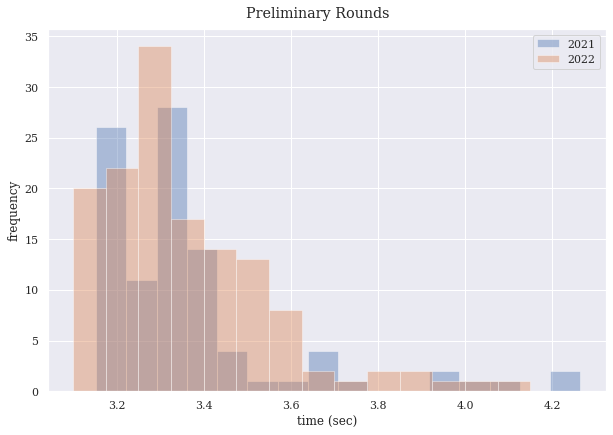

In [ ]:
comps = {'Year' : ["2021", "2022"]}
compare_hist(prelims_df, comps, title="Preliminary Rounds",
         hist=True, norm_hist=False, kde=False)

As there were fewer competitors in 2021, let's normalize the results. Also, to facilitate year-to-year comparisons, we'll smooth the histograms and add lines representing average time by year.

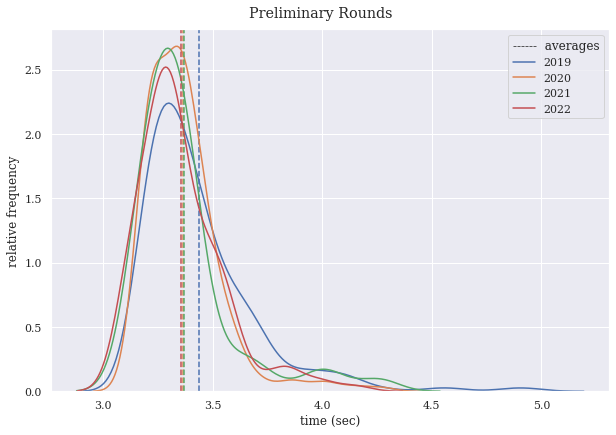

In [ ]:
compare_hist(prelims_df, comps, title="Preliminary Rounds",
         hist=False, norm_hist=True, kde=True)

We see that the years 2020-2022 had close to the same average time and spread of times. 2019 was not only slower but less consistent: the times were distributed less tightly around the average.

Average Time by car in the prelims, the top 10. Z-score, or standard score, indicates how fast each car was that in terms of standard deviations from the overall average. See https://en.wikipedia.org/wiki/Standard_score for more info.

In [8]:
filter_dict = {'Year' :['2022']}
top_times(prelims_df, filter_dict, means=True, top=10)

,Car,Last Name,First Name,Time,Stdev,Z-score
1,13,Schoonover,Aubrey,3.119600,0.037263,-1.326765
2,9,Schoonover,Isaac,3.124933,0.020554,-1.296650
3,12,Schoonover,Adelyn,3.147100,0.047961,-1.171487
4,8,Evers,Charlie,3.164500,0.015417,-1.073238
5,34,Kennedy,Salem,3.200733,0.013302,-0.868648
6,2,Von Tunglen,Hudson,3.252833,0.043648,-0.574467
7,15,Teske,Pippa,3.258367,0.013078,-0.543223
8,19,Tipton,Frances,3.264367,0.018084,-0.509344
9,1,Von Tunglen,Mira,3.287883,0.041069,-0.376558
10,11,Pool,James,3.311150,0.027069,-0.245184


And here are the top 10 individual Times in the prelims.

In [9]:
filter_dict = {'Year' :['2022']}
top_times(prelims_df, filter_dict, means=False, top=10)

,index,Car,Last Name,First Name,Lane,Time,Z-score
1,1441,13,Schoonover,Aubrey,2,3.1001,-1.314971
2,1430,13,Schoonover,Aubrey,3,3.1021,-1.304636
3,1408,13,Schoonover,Aubrey,5,3.1050,-1.289650
4,1515,9,Schoonover,Isaac,4,3.1057,-1.286033
5,1439,13,Schoonover,Aubrey,6,3.1060,-1.284483
6,1419,13,Schoonover,Aubrey,4,3.1090,-1.268980
7,1489,9,Schoonover,Isaac,2,3.1110,-1.258646
8,1413,12,Schoonover,Adelyn,4,3.1141,-1.242627
9,1487,9,Schoonover,Isaac,6,3.1143,-1.241593
10,1402,12,Schoonover,Adelyn,5,3.1161,-1.232292


Of those scouts who competed in both 2021 and 2022, who improved the most?

In [33]:
most_improved(prelims_df, ['2021', '2022'])

,index,Last Name,First Name,Time_2022,Time_2021,Diff
1,9,Douthitt,Savannah Rose,3.315217,4.091233,-0.776017
2,8,Adams,Jonathan,3.335600,3.668133,-0.332533
3,2,Schoonover,Isaac,3.124933,3.201433,-0.076500
4,3,Evers,Charlie,3.164500,3.216200,-0.051700
5,0,Schoonover,Aubrey,3.119600,3.165367,-0.045767
6,1,Schoonover,Adelyn,3.147100,3.185933,-0.038833
7,4,Teske,Pippa,3.258367,3.223000,0.035367
8,6,Magann,Mason,3.461517,3.348767,0.112750
9,5,McCabe,Madison,3.556133,3.279867,0.276267
10,7,Douthitt,Brianna Lynn,3.872850,3.381700,0.491150


2021 had relatively few competitors, so of those scouts who competed in both 2020 and 2022, who improved the most?

In [34]:
most_improved(prelims_df, ['2020', '2022'])

,index,Last Name,First Name,Time_2022,Time_2020,Diff
1,11,Teske,Pippa,3.258367,3.512283,-0.253917
2,10,Franken,Zayne,3.368200,3.509050,-0.140850
3,3,Schoonover,Aubrey,3.119600,3.192467,-0.072867
4,1,Schoonover,Isaac,3.124933,3.183133,-0.058200
5,6,Adams,Jonathan,3.335600,3.384783,-0.049183
6,5,Douthitt,Savannah Rose,3.315217,3.347433,-0.032217
7,2,Evers,Charlie,3.164500,3.192350,-0.027850
8,9,Pool,Oliver,3.449300,3.453367,-0.004067
9,0,Schoonover,Adelyn,3.147100,3.141383,0.005717
10,7,Magann,Mason,3.461517,3.399567,0.061950


### Finals Rounds

Now let's compare the Finals round with previous years. First, run the usual stats.

In [35]:
finals = ['Finals']
finals_df = all_results_df[all_results_df.Round.isin(finals)]
finals_df.groupby(['Year'])['Time'].describe().round(3).T

Year,2018,2019,2020,2022
count,108.000,108.000,108.000,36.000
mean,3.295,3.226,3.227,3.155
std,0.093,0.048,0.069,0.053
min,3.183,3.134,3.122,3.090
25%,3.234,3.199,3.183,3.117
50%,3.268,3.216,3.209,3.142
75%,3.310,3.251,3.244,3.186
max,3.618,3.392,3.453,3.286


It appears that 2022 was faster than the previous best year 2019. Test whether the difference is significant or just chance.

In [ ]:
stats.ttest_ind(finals_df[finals_df.Year.isin(['2019'])]['Time'],
                finals_df[finals_df.Year.isin(['2022'])]['Time'])

Ttest_indResult(statistic=7.4934980254511085, pvalue=6.561849563592493e-12)

Since the pvalue<0.05, we can reject the null hypothesis that the samples (2019 and 2022) are drawn from the same process. In other words, 2022 was significantly faster than 2019 (and any other year).

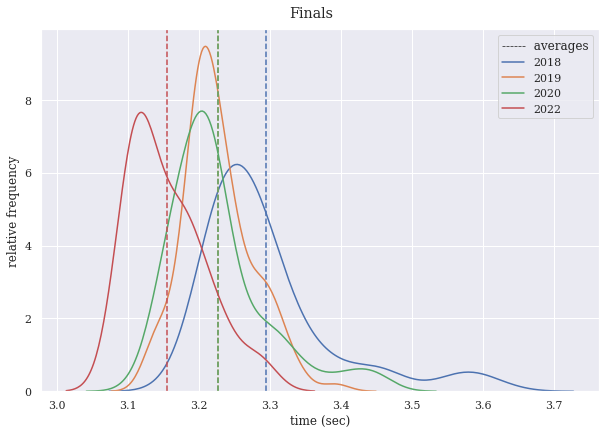

In [43]:
comps = {'Year' : [ '2018', '2019', '2020', '2022' ]}
compare_hist(finals_df, comps, title="Finals",
         hist=False, norm_hist=True, kde=True)

Average Time by car in the 2022 finals.

In [38]:
filter_dict = {'Year' :['2022']}
top_times(finals_df, filter_dict,means=True)

,Car,Last Name,First Name,Time,Stdev,Z-score
1,13,Schoonover,Aubrey,3.097517,0.006103,-1.047893
2,9,Schoonover,Isaac,3.117333,0.003921,-0.686015
3,12,Schoonover,Adelyn,3.124217,0.016413,-0.560317
4,8,Evers,Charlie,3.156867,0.013664,0.035914
5,34,Kennedy,Salem,3.187600,0.005451,0.597144
6,2,Von Tunglen,Hudson,3.245867,0.030359,1.661168


And here are the top 10 individual Times in the finals.

In [44]:
filter_dict = {'Year' :['2022']}
top_times(finals_df, filter_dict,means=False)

,index,Car,Last Name,First Name,Lane,Time,Z-score
1,1546,13,Schoonover,Aubrey,5,3.0903,-1.225446
2,1554,13,Schoonover,Aubrey,1,3.0919,-1.195094
3,1553,13,Schoonover,Aubrey,6,3.0940,-1.155258
4,1539,13,Schoonover,Aubrey,4,3.1022,-0.999706
5,1561,13,Schoonover,Aubrey,2,3.1030,-0.984530
6,1532,13,Schoonover,Aubrey,3,3.1037,-0.971251
7,1547,12,Schoonover,Adelyn,6,3.1048,-0.950384
8,1541,9,Schoonover,Isaac,6,3.1104,-0.844154
9,1555,12,Schoonover,Adelyn,2,3.1171,-0.717056
10,1542,9,Schoonover,Isaac,1,3.1172,-0.715160


### Lanes, Ages and the Schoonover Effect

Are there any differences among the lanes? First run the usual stats and plot the distributions.

In [46]:
lanes_df = prelims_df[prelims_df.Year.isin(['2022'])][['Lane','Time']]
lanes_df.groupby(['Lane']).describe().round(4).T

Lane              1        2        3        4        5        6
Time count  23.0000  23.0000  23.0000  23.0000  23.0000  23.0000
     mean    3.4019   3.3501   3.3394   3.3173   3.3576   3.3611
     std     0.2335   0.1805   0.1809   0.1596   0.2034   0.2060
     min     3.1568   3.1001   3.1021   3.1057   3.1050   3.1060
     25%     3.2423   3.2328   3.2286   3.2183   3.2440   3.2614
     50%     3.3177   3.3283   3.3098   3.2899   3.2913   3.2966
     75%     3.5422   3.4368   3.4186   3.3782   3.4367   3.4716
     max     4.1500   3.8526   3.9696   3.7629   3.8561   4.0083

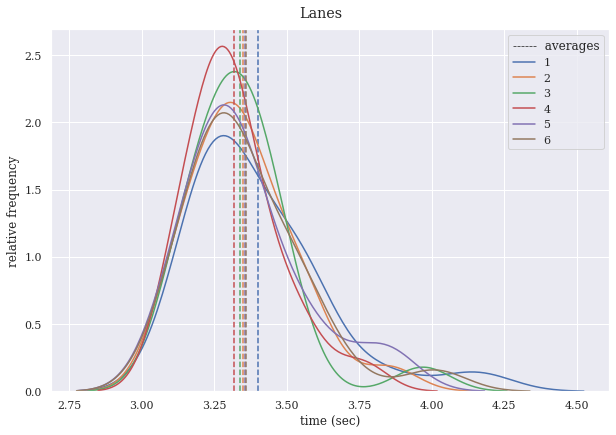

In [ ]:
comps = {'Lane' : [1,2,3,4,5,6]}
compare_hist(lanes_df, comps, title="Lanes",
         hist=False, norm_hist=True, kde=True)

It looks like lane one is a slower than the others. Do we see this when comparing the lane results of the fastest car?

In [47]:
filter_dict = {'Year' :['2022'], 'Car':[13]}
top_times(prelims_df, filter_dict, means=False)

,index,Car,Last Name,First Name,Lane,Time,Z-score
1,1441,13,Schoonover,Aubrey,2,3.1001,-0.523309
2,1430,13,Schoonover,Aubrey,3,3.1021,-0.469636
3,1408,13,Schoonover,Aubrey,5,3.1050,-0.391811
4,1439,13,Schoonover,Aubrey,6,3.1060,-0.364974
5,1419,13,Schoonover,Aubrey,4,3.1090,-0.284465
6,1398,13,Schoonover,Aubrey,1,3.1954,2.034195


Next, run a test between each pair of lanes to determine if the lane means are significantly different.

In [48]:
lanes = [1,2,3,4,5,6]

b = [[i, j] for i in lanes for j in lanes]
combos = []
for i in b:
    if i[0]<i[1]: 
        combos.append(i)

pvalues = []
for i in combos:
    e = lanes_df["Time"][lanes_df["Lane"]==i[0]]
    f = lanes_df["Time"][lanes_df["Lane"]==i[1]]
    pvalue = round(stats.ttest_ind(e, f)[1],4)
    pvalues.append(pvalue)

pd.DataFrame({'Lane Pair': combos,
              'P-value' : pvalues}).sort_values('P-value')


,Lane Pair,P-value
2,"[1, 4]",0.1587
1,"[1, 3]",0.3160
0,"[1, 2]",0.4050
13,"[4, 6]",0.4245
12,"[4, 5]",0.4588
3,"[1, 5]",0.4966
6,"[2, 4]",0.5170
4,"[1, 6]",0.5334
9,"[3, 4]",0.6626
11,"[3, 6]",0.7060


Since, for each pair of lanes, the probability is high (p-value>0.05) that the mean Time difference is chance, we can conclude there is no significant difference among the lanes. Please note that the significance level we choose (0.05) implies a confidence level of of 95%, and that it's just a convention. Had we chosen a confidence level of 80% (significance level of 0.20), lane 1 would be said to be significantly slower than lane 4.

#### The Schoonover Effect

Yes, there is one, and it's measurable and significant. On average and when controlling for scouts' ages and lanes, having the last name 'Schoonover' reduces the Time by around 0.22 seconds in both 2019 and 2020. See the coefficient for `Schoonover` in the results below.

Also note that each additional year in a scout's age reduces her time by around 0.03 seconds. This result is also significant.

In [50]:
df = prelims_df[prelims_df.Year.isin(['2022'])]

for i in zip(['Lion', 'Tiger', 'Wolf', 'Bear', 'Webelo', 'AOL'], range(6)):
    df.loc[df['Round']==i[0],'Age'] = i[1]

for i in [2,3,4,5,6]:
    df.loc[df['Lane']==i,'Lane'+str(i)] = 1

df.loc[df['Last Name']=='Schoonover','Schoonover'] = 1

for n in ['Age', 'Lane2','Lane3','Lane4','Lane5','Lane6', 'Schoonover']:
    df[n].fillna(0,inplace=True)

reg_form = "Time ~ Age + Lane2 + Lane3 + Lane4 + Lane5 + Lane6 + Schoonover"
result = sm.ols(formula=reg_form, data=df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     5.266
Date:                Fri, 11 Feb 2022   Prob (F-statistic):           2.58e-05
Time:                        13:11:56   Log-Likelihood:                 48.561
No. Observations:                 138   AIC:                            -81.12
Df Residuals:                     130   BIC:                            -57.70
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4395      0.039     89.088      0.0

### Distributional Analysis and Fastest Possible Time

Let's look again at the histogram for the preliminary rounds.

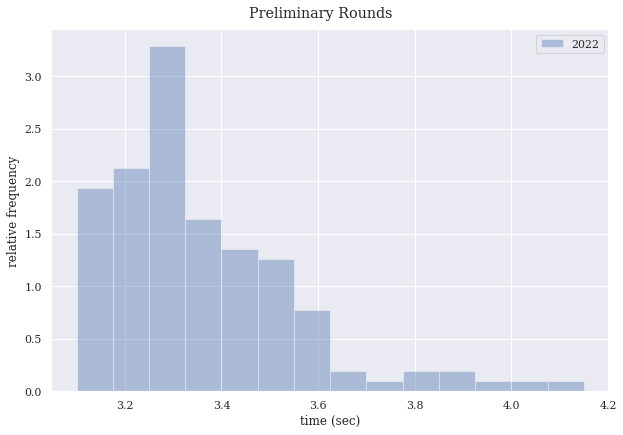

In [52]:
comps = {'Year' : ['2022']}
compare_hist(prelims_df, comps, title="Preliminary Rounds",
         hist=True, norm_hist=True, kde=False)

Can we say with confidence that the preliminaries' times are normally distributed (i.e. follow a bell curve)? Do a test for normality.

In [53]:
times = prelims_df[prelims_df.Year.isin(['2022'])]['Time']
stats.normaltest(times)

NormaltestResult(statistic=44.70283407389621, pvalue=1.962921437793354e-10)

Since the above p-value < 5% , we can reject the null hypothesis that Times are distributed normally. 

The histogram appears to have a long right tail and a hard boundary on the left. Perhaps a lognormal distribution is more appropriate. Superimpose a lognormal probability density function to the histogram and check visually for goodness of fit.

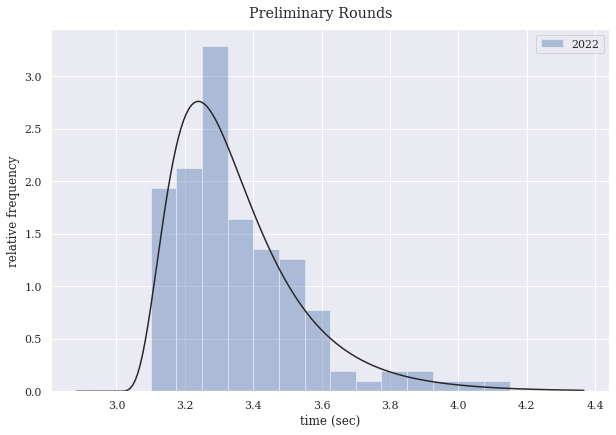

In [54]:
comps = {'Year' : ['2022']}
compare_hist(prelims_df, comps, title="Preliminary Rounds",
         hist=True, norm_hist=True, kde=False, fit=stats.lognorm)

The curve looks to fit the data well. I.e. the data appear to follow a lognormal distribution. Test for goodness of fit.

In [55]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html#scipy.stats.kstest
stats.kstest(times, "lognorm", stats.lognorm.fit(times))

KstestResult(statistic=0.07244479704715645, pvalue=0.44795694147730963)

Since the above p-value > 5% , we cannot reject the null hypothesis that Times follow a lognormal distribution. Also, we know that simulating the track physics yields a lognormal distribution of race times. See https://github.com/tedteske/DerbySim/blob/master/DerbySim.ipynb for details.

Now, estimate the parameters of that distribution, and plot a historgram of random draws from it to see if it resembles the original data. 

shape =  0.499
lower bound =  2.9836
distance from lower bound to median =  0.3279




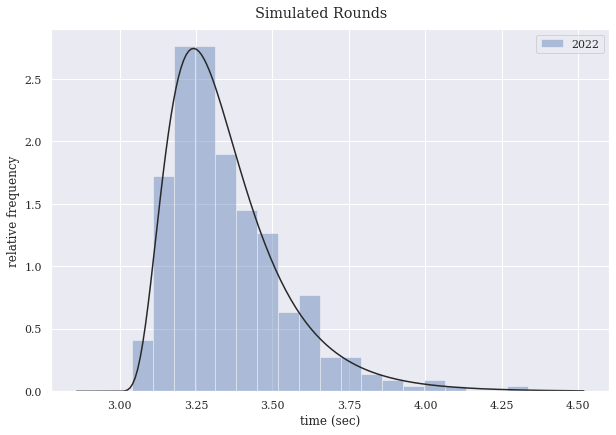

In [58]:
shape, floor, median = stats.lognorm.fit(times)

print("shape = ", shape.round(4))
print("lower bound = ", floor.round(4))
print("distance from lower bound to median = ", median.round(4))
print("\n")

dist = []
for i in range(324):
    x = stats.lognorm.rvs(s=shape, loc=floor, scale=median)
    dist.append(['2022', x])

df = pd.DataFrame(dist, columns = ['Year', 'Time'])  

comps = {'Year' : ['2022']}
compare_hist(df, comps_dict=comps, title="Simulated Rounds",
         hist=True, norm_hist=True, kde=False, fit=stats.lognorm)

Yes, sure does. 

If this curve then is representative, then what is the probability of some car out of this group running a time better than 3.2 seconds?

In [59]:
#https://matthew-brett.github.io/teaching/on_cdfs.html
stats.lognorm.cdf(x=3.2, s=shape, loc=floor, scale=median).round(4)

0.2023

What about the probability of running a time better than 3.1 seconds?

In [60]:
stats.lognorm.cdf(x=3.1, s=shape, loc=floor, scale=median).round(4)

0.0189

...which is consistent with the lower bound of the distribution above.  Note that this is also consistent with the fastest possible time (with stock wheels) of 3.05. 

See again https://github.com/tedteske/DerbySim/blob/master/DerbySim.ipynb for details.